In [1]:
import serial
import struct
import datetime

In [2]:
GET_SAMPLING_RATE_COMMAND = 0x03
SAMPLING_RATE_RESPONSE = 0x04
ACK_COMMAND_PROCESSED = 0xFF
STOP_STREAMING_COMMAND = 0x20
START_STREAMING_COMMAND = 0x07

In [3]:
# For every packet that the Shimmer3 receives, it sends an acknowledgement message
# (ACK_COMMAND_PROCESSED) back to the host, to acknowledge receipt of the command.
def wait_for_ack():
    """Wait for acknowledgement bit from device.

    Keyword arguments:
    ser -- serial port
    """
    ddata = ""
    ack = struct.pack('B', ACK_COMMAND_PROCESSED) # pack the given Python values according to the given format. 'B' means unsigned byte, the value passed to struct.pack() should be interpreted as an unsigned byte (8bits)
    # it packs the hexadeicmal value '0xff' into an unsigned btyes.
    while ddata != ack:
        ddata = ser.read(1)
        print(("received [%s]" % struct.unpack('B', ddata)))
        return

In [4]:
def accel_calc(data):
    """Calculate m/s^2 values of accelerometer from raw output.

    Keyword arguments:
    data -- raw data from device
    """
    value = (data - 2047) * float(1) / float(830) * float(9.80665)
    return value

def gyro_calc(data):
    """Calculate deg/s values of gyroscope from raw output.

    Keyword arguments:
    data -- raw data from device
    """
    value = data / float(65.5)
    return value

def mag_calc_xy(data):
    """Calculate gauss values of magnometer from raw output, X and Y.

    Keyword arguments:
    data -- raw data from device
    """
    value = data / float(1100)
    return value

def mag_calc_z(data):
    """Calculate gauss values of magnometer from raw output, Z.

    Keyword arguments:
    data -- raw data from device
    """
    value = data / float(980)
    return value

def emg_ch1_calc(data):
    """Calculate mV values of EMG from raw output.

    Keyword arguments:
    data -- raw data from device
    """
    value = (float(data) + float(15181.104693140795)) * float(0.00002404054)
    return value

def emg_ch2_calc(data):
    """Calculate mV values of EMG from raw output.

    Keyword arguments:
    data -- raw data from device
    """
    value = (float(data) - float(13640.723039215687)) * float(0.00002404054)
    return value



In [5]:
# Open Serial Port
ser = serial.Serial('/dev/rfcomm0', 460800)
ser.flushInput()

In [6]:
# Stop Streaming
ser.write(struct.pack('B', STOP_STREAMING_COMMAND))
wait_for_ack()

received [255]


In [7]:
# Get Sampling Rate
# when the Shimmer3 receives the GET_SAMPLING_RATE_COMMAND, it must send the
# current value of the sampling rate back to the host; 
# the response packet will contain two bytes: the first byte will be the SAMPLING_RATE_REPONSE identifier
# and the second byte will be the sampling
# rate value. 
ser.write(struct.pack('B', GET_SAMPLING_RATE_COMMAND))
wait_for_ack()
ddata = ser.read(3)
ddata = struct.unpack('<BH', ddata)
print('Sampling Rate is: %f' % (32768 / ddata[1]))

received [255]
Sampling Rate is: 60.124771


In [8]:
# Start Streaming
ser.write(struct.pack('B', 0x07))
wait_for_ack()
numbytes = 0
ddata = b''
framesize = 1 + 3 + 2*3 + 2*3 + 2*3 + 7
all_emg_ch1 = []
all_emg_ch2 = []
while True:
    while numbytes < framesize:
        ddata += ser.read(framesize)
        numbytes = len(ddata)

    data = ddata[0:framesize]
    numbytes = 0
    ddata = b''

    (packettype) = struct.unpack('B', data[0:1]) #[0]

    (lin_acc_raw_x, lin_acc_raw_y, lin_acc_raw_z) = struct.unpack('HHH', data[4:10])
    lin_acc_cal_x = accel_calc(lin_acc_raw_x)
    lin_acc_cal_y = accel_calc(lin_acc_raw_y)
    lin_acc_cal_z = accel_calc(lin_acc_raw_z)
    
    (ang_vel_raw_x, ang_vel_raw_y, ang_vel_raw_z) = struct.unpack('>hhh', data[10:16])
    ang_vel_cal_x = gyro_calc(ang_vel_raw_x)
    ang_vel_cal_y = gyro_calc(ang_vel_raw_y)
    ang_vel_cal_z = gyro_calc(ang_vel_raw_z)

    (mag_fld_raw_x, mag_fld_raw_z, mag_fld_raw_y) = struct.unpack('>hhh', data[16:22])
    mag_fld_cal_x = mag_calc_xy(mag_fld_raw_x)
    mag_fld_cal_y = mag_calc_xy(mag_fld_raw_y)
    mag_fld_cal_z = mag_calc_z(mag_fld_raw_z)

    emg_ch1_raw = struct.unpack('>i', (data[23:26] + b'\0'))[0] >> 8
    emg_ch2_raw = struct.unpack('>i', (data[26:29] + b'\0'))[0] >> 8

    emg_ch1_cal = emg_ch1_calc(emg_ch1_raw)
    emg_ch2_cal = emg_ch2_calc(emg_ch2_raw)  

    all_emg_ch1.append(emg_ch1_cal)
    all_emg_ch2.append(emg_ch2_cal)

    

received [255]


KeyboardInterrupt: 

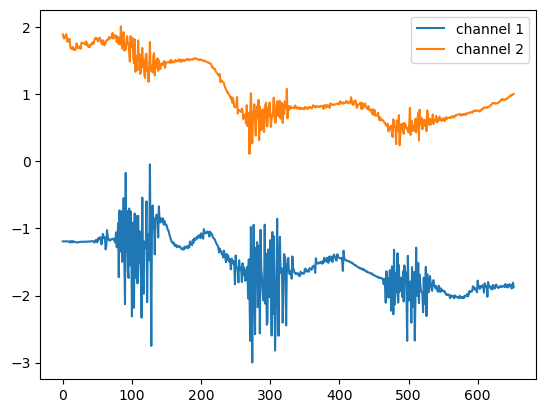

In [9]:
import matplotlib.pyplot as plt
import numpy as np

all_emg_ch1 = np.array(all_emg_ch1)
all_emg_ch2 = np.array(all_emg_ch2)

plt.plot(all_emg_ch1, label='channel 1')
plt.plot(all_emg_ch2, label='channel 2')
plt.legend()